<a href="https://colab.research.google.com/github/AKASH4671/time-series-analysis/blob/main/Multivariate_Time_Series_Anomaly_Detection_using_VAR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
%matplotlib inline


from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

<ipython-input-235-7379214f9fb8>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read File & Data Pre-Processing**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SEM 2/Data/data.xlsx')
df.head(5)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.9
1,2017-01-01 00:05:00,879.23,918.14,-184.33,-182.1,862.53,-149.76
2,2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# setting time as index
# WARNING INPLACE WILL CHANGE THE DATA MAKE SURE TO KEEP A COPY OF DATA IN SAFE SIDE
df.set_index('time', inplace = True)
data = df

In [ ]:
data

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.9
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.1,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39
...,...,...,...,...,...,...
2020-08-07 11:55:00,899.42,919.79,-224.07,-209.77,901.01,-175.15
2020-08-07 12:00:00,879.9,895.02,-228.04,-211.28,878.08,-176.94
2020-08-07 12:05:00,887.2,895.7,-230.11,-214.65,885.32,-179.18


In [ ]:
# converting obj data type to float
object_columns = data.select_dtypes(include='object').columns
data[object_columns] = data[object_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')

print(data.dtypes)

Cyclone_Inlet_Gas_Temp      float64
Cyclone_Material_Temp       float64
Cyclone_Outlet_Gas_draft    float64
Cyclone_cone_draft          float64
Cyclone_Gas_Outlet_Temp     float64
Cyclone_Inlet_Draft         float64
dtype: object


In [ ]:
# checking nan values
data.isna().sum()

Cyclone_Inlet_Gas_Temp      1320
Cyclone_Material_Temp       1591
Cyclone_Outlet_Gas_draft    1321
Cyclone_cone_draft          1320
Cyclone_Gas_Outlet_Temp     1321
Cyclone_Inlet_Draft         1322
dtype: int64

In [ ]:
# ffill the nan
data = data.fillna(method='ffill')

In [ ]:
# resample from 5min to a week data
data = data.resample('W').mean()

In [ ]:
data.head()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01,881.853993,934.871319,-180.023368,-163.740868,870.411042,-144.056111
2017-01-08,891.102321,929.531860,-193.685451,-173.953299,862.861538,-157.611791
2017-01-15,883.511275,912.125699,-189.722436,-177.395561,848.368621,-149.120903
2017-01-22,888.438204,921.760982,-185.318924,-171.295531,852.843591,-145.792574
2017-01-29,880.036920,921.281290,-166.722178,-163.435858,857.372961,-146.626895


**Checking if the data is Stationary or not**

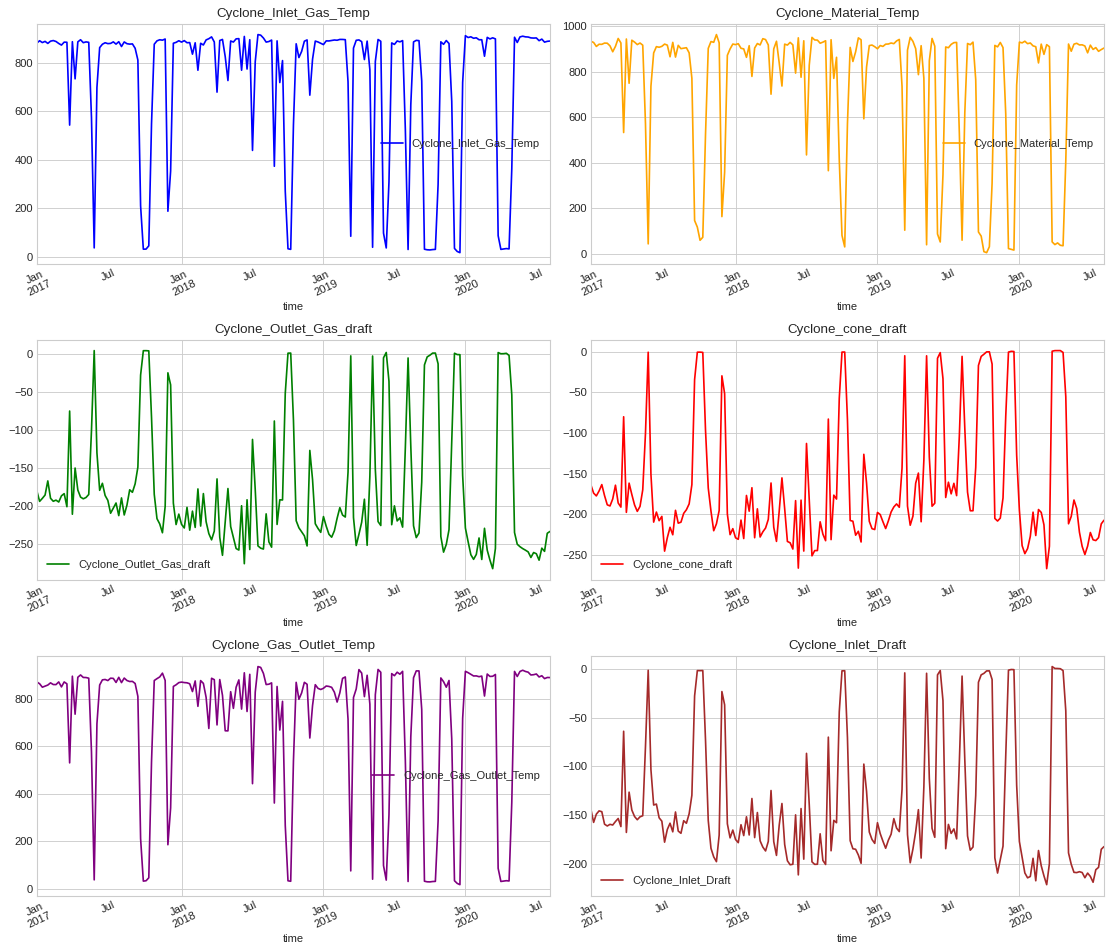

In [ ]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
]


def Visualize(data):
    features= list(data.columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(data)

In [ ]:
# The Augmented Dickey-Fuller test
for i in range(len(data.columns)):
  result = adfuller(data[data.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(data.columns[i]))
  else:
    print('{} - Series is Stationary'.format(data.columns[i]))

Cyclone_Inlet_Gas_Temp - Series is Stationary
Cyclone_Material_Temp - Series is Stationary
Cyclone_Outlet_Gas_draft - Series is Stationary
Cyclone_cone_draft - Series is Stationary
Cyclone_Gas_Outlet_Temp - Series is Stationary
Cyclone_Inlet_Draft - Series is Stationary


**Granger Causality Statistical Test**

In [ ]:
max_lags=8
y='Cyclone_Inlet_Gas_Temp'

In [ ]:
for i in range(len(data.columns)-1):
  results=grangercausalitytests(data[[y,data.columns[i+1]]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(data.columns[i+1],p_values))

Column - Cyclone_Material_Temp : P_Values - [0.8864, 0.1298, 0.1008, 0.1684, 0.2403, 0.3329, 0.2841, 0.3549]
Column - Cyclone_Outlet_Gas_draft : P_Values - [0.6481, 0.9629, 0.9979, 0.9412, 0.9966, 0.7697, 0.5734, 0.4583]
Column - Cyclone_cone_draft : P_Values - [0.6828, 0.5874, 0.6164, 0.7506, 0.8083, 0.7566, 0.6516, 0.7624]
Column - Cyclone_Gas_Outlet_Temp : P_Values - [0.1519, 0.2019, 0.264, 0.2345, 0.2547, 0.3909, 0.5881, 0.4072]
Column - Cyclone_Inlet_Draft : P_Values - [0.7109, 0.9248, 0.9998, 0.8645, 0.9698, 0.7522, 0.5401, 0.5234]


**VAR Model**

In [ ]:
max_lag = 25

In [ ]:
model = VAR(data, freq="W")

**optimal lag order using information criteria**

In [ ]:
# select the best order for the lag
lag_results = model.select_order(max_lag).summary()
lag_results

,AIC,BIC,FPE,HQIC
0,39.98,40.09,2.297e+17,40.02
1,37.07,37.87*,1.260e+16*,37.39
2,37.24,38.71,1.492e+16,37.84
3,37.40,39.56,1.764e+16,38.28
4,37.51,40.34,1.972e+16,38.66
5,37.72,41.24,2.477e+16,39.15
6,37.81,42.00,2.753e+16,39.51
7,37.86,42.74,2.990e+16,39.84
8,37.91,43.47,3.264e+16,40.17
9,38.07,44.30,4.005e+16,40.60


In [ ]:
lag_results = model.select_order(max_lag)
selected_lag = lag_results.bic

**summary of the model**

In [ ]:
# the model
model = VAR(data, freq = "W")
results = model.fit(selected_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Jun, 2023
Time:                     10:23:57
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    37.6391
Nobs:                     188.000    HQIC:                   37.2090
Log likelihood:          -5028.68    FPE:                1.07782e+16
AIC:                      36.9161    Det(Omega_mle):     8.65536e+15
--------------------------------------------------------------------
Results for equation Cyclone_Inlet_Gas_Temp
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                             252.189920        46.870925            5.381           0.000
L1.Cyclone_Inlet_Gas_Temp           1.628551         0.970557            1.678    

**Anomalies detection**

In [ ]:
# find anomalies
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var_fitresults = results
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)

In [ ]:
find_anomalies(squared_errors)

(time
 2017-01-08    0
 2017-01-15    0
 2017-01-22    0
 2017-01-29    0
 2017-02-05    0
              ..
 2020-07-12    0
 2020-07-19    0
 2020-07-26    0
 2020-08-02    0
 2020-08-09    0
 Freq: W-SUN, Length: 188, dtype: int64,
 836226.620720498)

In [ ]:
data = data.iloc[selected_lag: , :]
data['predictions'] = predictions.values
data

<ipython-input-256-c494d7d3ae71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predictions'] = predictions.values


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,predictions
time,,,,,,,
2017-01-08,891.102321,929.531860,-193.685451,-173.953299,862.861538,-157.611791,0
2017-01-15,883.511275,912.125699,-189.722436,-177.395561,848.368621,-149.120903,0
2017-01-22,888.438204,921.760982,-185.318924,-171.295531,852.843591,-145.792574,0
2017-01-29,880.036920,921.281290,-166.722178,-163.435858,857.372961,-146.626895,0
2017-02-05,889.344484,926.856840,-189.598338,-176.970481,866.649821,-159.461438,0
...,...,...,...,...,...,...,...
2020-07-12,891.357698,898.974301,-271.173214,-231.417684,891.464380,-219.235893,0
2020-07-19,897.854360,907.011994,-255.315149,-232.329881,896.603904,-206.319812,0
2020-07-26,885.312674,890.643343,-259.548313,-228.771200,884.502852,-203.926597,0


In [ ]:
data['predictions'].value_counts()

0    170
1     18
Name: predictions, dtype: int64

**Final Output**

In [ ]:
result = data[data['predictions'] == 1]
result

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,predictions
time,,,,,,,
2017-05-28,37.044023,44.027996,4.993393,-0.486200,37.519276,-1.060714,1
2017-06-04,698.812158,737.306870,-129.759201,-150.737852,694.385481,-103.367555,1
2017-09-24,210.178085,146.540779,-27.275198,-34.239345,210.808983,-27.446885,1
2017-12-03,188.048814,163.815164,-24.302495,-29.568676,185.207674,-22.994886,1
2018-09-02,373.413239,365.793160,-87.770536,-82.770317,360.677297,-69.882718,1
2018-09-30,270.952703,415.228274,-51.333770,-57.600466,266.676364,-43.975050,1
2018-10-07,33.345417,81.086116,1.576334,-0.327406,33.484762,-1.656582,1
2019-03-17,85.019807,104.170288,-2.034043,-4.911791,75.246453,-3.797589,1
2019-03-24,860.804812,895.778120,-214.975005,-189.888457,804.856523,-170.202416,1


In [ ]:
result.index

DatetimeIndex(['2017-05-28', '2017-06-04', '2017-09-24', '2017-12-03',
               '2018-09-02', '2018-09-30', '2018-10-07', '2019-03-17',
               '2019-03-24', '2019-05-12', '2019-05-19', '2019-06-09',
               '2019-06-30', '2019-08-11', '2019-09-22', '2019-12-08',
               '2019-12-29', '2020-03-29'],
              dtype='datetime64[ns]', name='time', freq=None)